# Momento de Retroalimentación: Módulo 1 Utilización, procesamiento y visualización de grandes volúmenes de datos (Portafolio Análisis)

## Introducción

El presente dataset recopila los primeros 30 segundos de transacciones posteriores al minting de tokens creados en la plataforma PumpFun durante septiembre de 2025, utilizando datos extraídos desde un nodo privado de la red Solana. Cada registro incluye información detallada sobre la actividad inicial del token, como la dirección del creador, volumen operado, compras y ventas, variaciones en el suministro, capitalización de mercado, comisiones, métricas de liquidez y diversos indicadores técnicos como RSI, Bollinger Bands y Money Flow Index. Estos datos permiten analizar el comportamiento del mercado en las etapas más tempranas de un token, donde se concentra gran parte de la especulación y volatilidad.

El objetivo del análisis es predecir si un token será comprado por traders clasificados como “alpha”, es decir, inversores con comportamientos estratégicos o de alto rendimiento. Esto plantea un problema de clasificación binaria donde la variable objetivo bought_by_alpha indica si el token fue adquirido (1) o no (0). Comprender qué características influyen en estas decisiones permite identificar tokens con potencial temprano, evaluar riesgos y optimizar estrategias en mercados altamente dinámicos como Solana.

Link del dataset: https://www.kaggle.com/datasets/twainayar/pumpfun-30s-september-2025


## Visualización Inicial de los Datos
Link a Tableau public: https://public.tableau.com/app/profile/tom.s.p.rez3686/viz/MomentodeRetroalimentacinMddulo1/Dashboard1?publish=yes

El dashboard presenta una visión clara y estructurada del comportamiento de los tokens generados en la plataforma PumpFun durante los primeros segundos posteriores a su creación. En la parte superior, se muestran indicadores clave (KPIs) que resumen el estado general del mercado, incluyendo el número total de tokens analizados, el market cap acumulado, el volumen negociado en SOL, así como el número de holders actuales y únicos. Justo debajo, se incluye una tabla tipo ranking que permite comparar los tokens más relevantes según métricas como market cap, volumen o actividad de compra y venta, facilitando la identificación de los proyectos con mayor tracción o comportamiento atípico.

El dashboard también integra gráficos para analizar tendencias temporales y patrones del mercado. Por ejemplo, se observa la evolución del capitalización del mercado y del volumen, lo que ayuda a entender momentos de mayor actividad o posibles señales de especulación. En conjunto, el panel combina métricas financieras, comportamientos de usuarios e indicadores técnicos, ofreciendo una herramienta útil para explorar qué tokens ganan popularidad, cómo reaccionan los inversores en tiempo real y qué características podrían indicar un comportamiento exitoso o riesgoso.

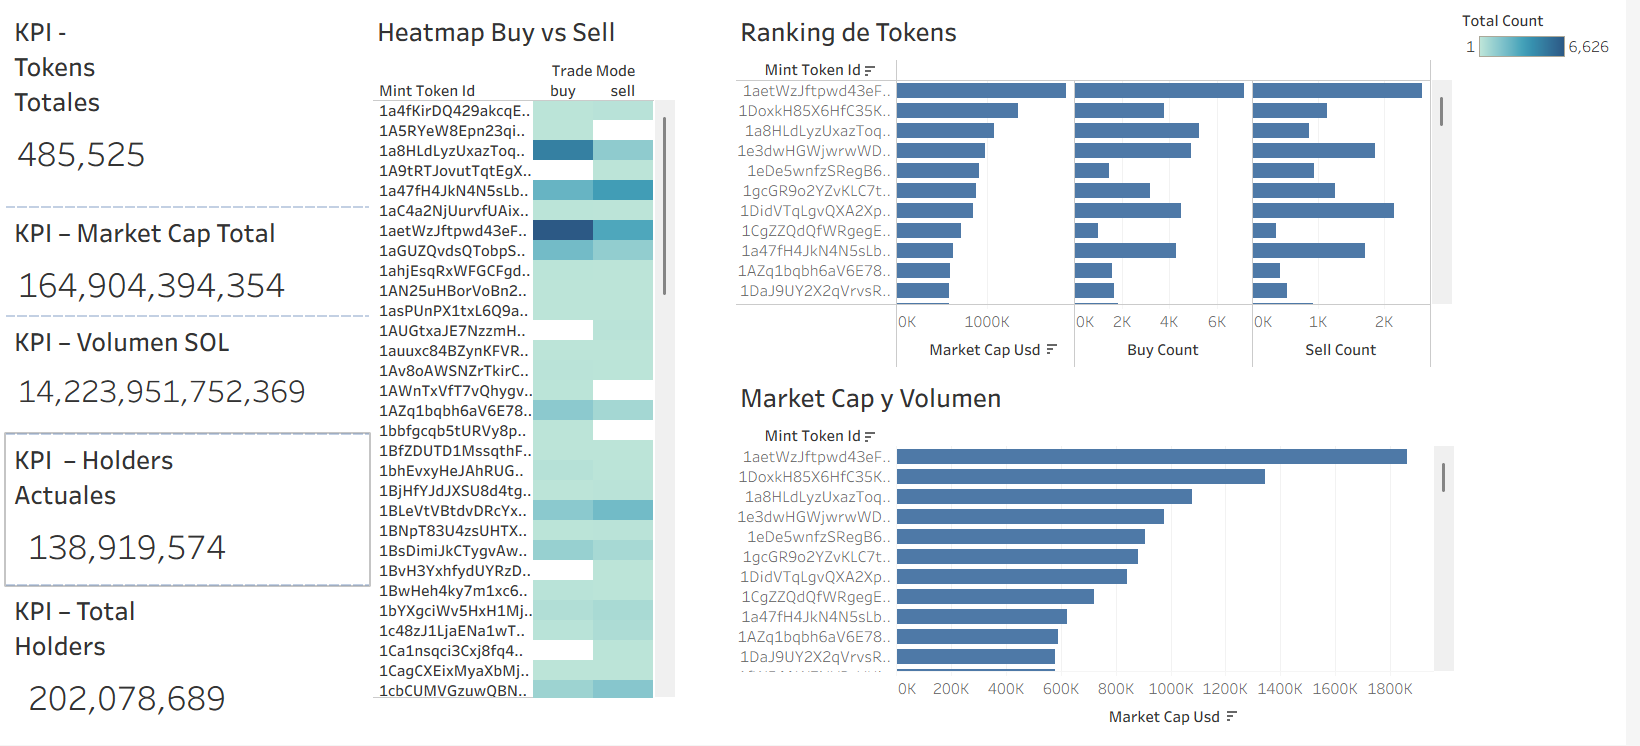

## Montar Entorno

In [ ]:
#Bibliotecas para poder trabajar con Spark
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.7/spark-3.5.7-bin-hadoop3.tgz
!tar xf spark-3.5.7-bin-hadoop3.tgz
#Configuración de Spark con Python
!pip install -q findspark
!pip install pyspark

#Estableciendo variable de entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.7-bin-hadoop3"

#Buscando e inicializando la instalación de Spark
import findspark
findspark.init()
findspark.find()

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://cli.github.com/packages stable InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
46 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as re

'/content/spark-3.5.7-bin-hadoop3'

## Conectar Drive

In [ ]:
# Montar Google Drive (te pedirá autorización)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Generar Sesión de Spark

In [ ]:
from pyspark.sql import SparkSession

# Funciones de PySpark SQL
from pyspark.sql.functions import (
    col, when, sum, avg, max, min, count, countDistinct,
    stddev, lit, desc
)

# Tipos de datos de PySpark (probablemente no los necesites en este proyecto)
from pyspark.sql.types import (
    StructType, StructField, StringType, IntegerType,
    DoubleType, TimestampType
)

In [ ]:
# Crear sesión Spark
spark = SparkSession.builder \
    .appName("PumpFun_Token_Classification") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "10") \
    .getOrCreate()

df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("/content/drive/MyDrive/ConcentracionIA2/Big Data/Reto/archive/*.csv")

Resumen del dataset

In [ ]:
print("="*80)
print("DATASET INFORMATION")
print("="*80)
print(f"Registry Total: {df.count():,}")
print(f"Column Total: {len(df.columns)}")
print(f"Unique Tokens: {df.select('mint_token_id').distinct().count():,}")

DATASET INFORMATION
Registry Total: 9,478,706
Column Total: 34
Unique Tokens: 485,525


Esquema del dataset

In [ ]:
# Mostrar esquema
print("DATASET SCHEMA")
df.printSchema()

DATASET SCHEMA
root
 |-- index: integer (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- mint_token_id: string (nullable = true)
 |-- holder: string (nullable = true)
 |-- trade_mode: string (nullable = true)
 |-- token_quantity: double (nullable = true)
 |-- creator: string (nullable = true)
 |-- creator_fee: double (nullable = true)
 |-- creator_fee_pump: double (nullable = true)
 |-- market_cap_usd: double (nullable = true)
 |-- token_delta: double (nullable = true)
 |-- sol_delta: double (nullable = true)
 |-- buy_count: integer (nullable = true)
 |-- sell_count: integer (nullable = true)
 |-- total_count: integer (nullable = true)
 |-- token_volume: double (nullable = true)
 |-- sol_volume: double (nullable = true)
 |-- liquidity_ratio: double (nullable = true)
 |-- virtual_sol_reserves: double (nullable = true)
 |-- virtual_token_reserves: double (nullable = true)
 |-- consumed_gas: integer (nullable = true)
 |-- fee: integer (nullable = true)
 |-- relative_strengt

Estatdisiticas generales del dataset

In [ ]:
# Estadísticas básicas
print("DATASET STATISTICS")
df.describe().show()

DATASET STATISTICS
+-------+------------------+---------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+-----------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+----------------------+------------------+------------------+-----------------------+---------------------------+------------------+-------------------+-----------------+------------------+------------------+--------------------+-------------------+------------------+------------------+
|summary|             index|timestamp|       mint_token_id|              holder|trade_mode|      token_quantity|             creator|         creator_fee|    creator_fee_pump|    market_cap_usd|         token_delta|           sol_delta|        buy_count|        sell_count|      total_count|        token_volume|      

Verificación de valores nulos por campo

In [ ]:
# Verificar valores nulos
print("NULL VALUES PER COLUMN:")
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


NULL VALUES PER COLUMN:
+-----+---------+-------------+------+----------+--------------+-------+-----------+----------------+--------------+-----------+---------+---------+----------+-----------+------------+----------+---------------+--------------------+----------------------+------------+---+-----------------------+---------------------------+-----------------+--------------+----------------+-------------+---------------+-------------------+---------------+------------+------------+--------------+
|index|timestamp|mint_token_id|holder|trade_mode|token_quantity|creator|creator_fee|creator_fee_pump|market_cap_usd|token_delta|sol_delta|buy_count|sell_count|total_count|token_volume|sol_volume|liquidity_ratio|virtual_sol_reserves|virtual_token_reserves|consumed_gas|fee|relative_strength_index|bollinger_relative_position|volume_oscillator|rate_of_change|money_flow_index|total_holders|current_holders|top10_percent_total|creator_balance|creator_sold|holder_ratio|buy_sell_ratio|
+-----+-----

En esta parte de código, se agrupan los datos por cada token (mint_token_id) y genera un conjunto de características agregadas que permiten describir su comportamiento en el mercado. Para cada token, calcula métricas de actividad como el total de compras, ventas y su relación, volúmenes totales y promedio operados en SOL y en tokens, así como estadísticas del market cap (promedio, máximo, mínimo y desviación estándar). También incluye indicadores sobre los holders, como el número máximo de holders históricos, holders actuales y la concentración del top 10 %. Del lado del creador del token, se registra cuántos tokens ha vendido, su balance final y las comisiones recibidas. Además, se calculan promedios de indicadores técnicos como RSI, Bollinger, Money Flow Index, volumen oscilador y liquidez, junto con el consumo total de gas, fees pagadas, reservas virtuales del pool y finalmente el número total de transacciones y de wallets únicas que interactuaron con el token. Esta información es clave para alimentar modelos de clasificación o análisis de comportamiento de tokens.

In [ ]:
print("GENERATING FEATURES PER TOKEN")

# Crear features por token (necesarias para clasificación)
token_features = df.groupBy('mint_token_id').agg(
    # Métricas de trading
    sum(when(col('trade_mode') == 'buy', 1).otherwise(0)).alias('total_buys'),
    sum(when(col('trade_mode') == 'sell', 1).otherwise(0)).alias('total_sells'),
    (sum(when(col('trade_mode') == 'buy', 1).otherwise(0)) /
    (sum(when(col('trade_mode') == 'sell', 1).otherwise(0)) + 1)).alias('buy_sell_ratio_calc'),

    # Métricas de volumen
    sum('sol_volume').alias('total_sol_volume'),
    sum('token_volume').alias('total_token_volume'),
    avg('sol_volume').alias('avg_sol_volume'),

    # Métricas de mercado
    avg('market_cap_usd').alias('avg_market_cap'),
    max('market_cap_usd').alias('max_market_cap'),
    min('market_cap_usd').alias('min_market_cap'),
    stddev('market_cap_usd').alias('std_market_cap'),

    # Métricas de holders
    max('total_holders').alias('max_total_holders'),
    max('current_holders').alias('final_holders'),
    avg('top10_percent_total').alias('avg_concentration'),
    max('top10_percent_total').alias('max_concentration'),

    # Métricas de creador
    max('creator_sold').alias('creator_tokens_sold'),
    max('creator_balance').alias('creator_final_balance'),
    sum('creator_fee').alias('total_creator_fees'),
    avg('holder_ratio').alias('avg_holder_ratio'),

    # Indicadores técnicos
    avg('relative_strength_index').alias('avg_rsi'),
    max('relative_strength_index').alias('max_rsi'),
    min('relative_strength_index').alias('min_rsi'),
    avg('bollinger_relative_position').alias('avg_bollinger'),
    avg('volume_oscillator').alias('avg_volume_osc'),
    avg('money_flow_index').alias('avg_mfi'),
    avg('liquidity_ratio').alias('avg_liquidity_ratio'),

    # Métricas de gas y fees
    sum('consumed_gas').alias('total_gas'),
    sum('fee').alias('total_fees'),
    avg('fee').alias('avg_fee'),

    # Métricas de reservas virtuales
    avg('virtual_sol_reserves').alias('avg_sol_reserves'),
    avg('virtual_token_reserves').alias('avg_token_reserves'),

    # Contadores
    count('*').alias('total_transactions'),
    countDistinct('holder').alias('unique_holders_interacted')
)

GENERATING FEATURES PER TOKEN


Aqui se limpian los datos generados anteriormente y mostrar un resumen. Primero, reemplaza todos los valores nulos dentro del DataFrame token_features por ceros usando na.fill(0) para evitar errores en etapas posteriores de análisis o modelado. Luego imprime la cantidad total de tokens para los cuales se generaron características y finalmente muestra las primeras cinco filas del DataFrame para verificar visualmente que los datos se hayan procesado correctamente.

In [ ]:
# Manejar valores nulos e infinitos
token_features = token_features.na.fill(0)

print(f"Features generadas: {token_features.count():,} tokens")
token_features.show(5)

Features generadas: 485,525 tokens
+--------------------+----------+-----------+-------------------+--------------------+--------------------+--------------------+------------------+--------------+--------------+------------------+-----------------+-------------+--------------------+-----------------+-------------------+---------------------+------------------+------------------+-----------------+-----------+-------+-----------------+--------------+------------------+--------------------+---------+----------+-----------------+--------------------+--------------------+------------------+-------------------------+
|       mint_token_id|total_buys|total_sells|buy_sell_ratio_calc|    total_sol_volume|  total_token_volume|      avg_sol_volume|    avg_market_cap|max_market_cap|min_market_cap|    std_market_cap|max_total_holders|final_holders|   avg_concentration|max_concentration|creator_tokens_sold|creator_final_balance|total_creator_fees|  avg_holder_ratio|          avg_rsi|    max_rsi|min

In [ ]:
ml_data = token_features.withColumn(
    'bought_by_alpha',
    when(
        (col('total_buys') > 10) &
        (col('avg_market_cap') > 50000) &
        (col('avg_rsi') > 50),
        1
    ).otherwise(0)
)

# Verificar distribución del target
print("DISTRIBUCIÓN DEL TARGET:")
ml_data.groupBy('bought_by_alpha').count().show()

DISTRIBUCIÓN DEL TARGET:
+---------------+------+
|bought_by_alpha| count|
+---------------+------+
|              0|485501|
|              1|    24|
+---------------+------+



Selección de atributos numéricos para el entrenamiento del modelo

In [ ]:
# Seleccionar columnas numéricas para el modelo
feature_cols = [
    'total_buys', 'total_sells', 'buy_sell_ratio_calc',
    'total_sol_volume', 'total_token_volume', 'avg_sol_volume',
    'avg_market_cap', 'max_market_cap', 'std_market_cap',
    'max_total_holders', 'final_holders', 'avg_concentration',
    'creator_tokens_sold', 'total_creator_fees', 'avg_holder_ratio',
    'avg_rsi', 'max_rsi', 'avg_bollinger', 'avg_volume_osc',
    'avg_mfi', 'avg_liquidity_ratio', 'total_gas', 'total_transactions',
    'unique_holders_interacted'
]

Eliminación de valores nulos en los campos seleccionados

In [ ]:
# Eliminar filas con valores nulos en features
ml_data_clean = ml_data.select(['mint_token_id', 'bought_by_alpha'] + feature_cols).na.drop()

División de datos en conjunto de entrenamiento y pruebas, 80% de los datos para entrenamiento y 20% para prueba

In [ ]:
train_data, test_data = ml_data_clean.randomSplit([0.8, 0.2], seed=42)

print(f"DATA SPLITTING")
print(f"Training: {train_data.count():,} registros")
print(f"Testing: {test_data.count():,} registros")

DATA SPLITTING
Training: 388,705 registros
Testing: 96,820 registros


En esta fase se construye una etapa de preparación y modelado para machine learning usando PySpark. Primero, el VectorAssembler combina todas las columnas numéricas seleccionadas (feature_cols) en un solo vector llamado features_raw, que es el formato requerido por los modelos de Spark. Luego, el StandardScaler normaliza estas características para que tengan media cero y desviación estándar uno, generando la columna features, lo cual mejora el rendimiento del modelo. Posteriormente, se define un clasificador RandomForestClassifier que entrenará un modelo de bosque aleatorio usando las features escaladas para predecir si un token fue comprado por un trader “alpha” (bought_by_alpha). Finalmente, se crea un Pipeline que encadena automáticamente estos pasos (ensamble de features, escalado y modelado), garantizando un flujo ordenado y reproducible durante el entrenamiento y la predicción.

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
# VectorAssembler: combina todas las features en un vector
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features_raw"
)

# StandardScaler: normaliza las features
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withStd=True,
    withMean=True
)

# Modelo: Random Forest Classifier
rf = RandomForestClassifier(
    labelCol="bought_by_alpha",
    featuresCol="features",
    numTrees=100,
    maxDepth=10,
    seed=42
)

# Crear pipeline
pipeline = Pipeline(stages=[assembler, scaler, rf])

Entrenamiento del modelo

In [ ]:
print("TRAINING RANDOM FOREST")
model = pipeline.fit(train_data)

TRAINING RANDOM FOREST


Aquí se evalúa el rendimiento del modelo entrenado. Primero, se generan predicciones sobre el conjunto de prueba (test_data) utilizando model.transform, y se muestran algunas filas con el identificador del token, la etiqueta real, la predicción y la probabilidad del modelo. Para medir su desempeño, se utiliza el AUC-ROC mediante BinaryClassificationEvaluator, una métrica que indica la capacidad del modelo para distinguir entre tokens comprados o no por compradores “alpha”. Luego se calculan métricas adicionales como accuracy, precision, recall y F1-score mediante MulticlassClassificationEvaluator, proporcionando una visión más completa del rendimiento. También se muestra la matriz de confusión para visualizar los aciertos y errores en cada clase. Finalmente, se extrae el modelo de Random Forest desde el pipeline y se calcula la importancia de cada feature, mostrando las 10 variables que más influyeron en las predicciones del modelo.

In [ ]:
# Hacer predicciones en test set
predictions = model.transform(test_data)

# Mostrar algunas predicciones
print("PREDICTIONS:")
predictions.select('mint_token_id', 'bought_by_alpha', 'prediction', 'probability').show(10, truncate=False)

print("MODEL EVALUATION")

# Evaluador para clasificación binaria (AUC-ROC)
binary_evaluator = BinaryClassificationEvaluator(
    labelCol="bought_by_alpha",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

auc = binary_evaluator.evaluate(predictions)
print(f"AUC-ROC: {auc:.4f}")

# Evaluador multiclase (para accuracy, precision, recall)
multi_evaluator = MulticlassClassificationEvaluator(
    labelCol="bought_by_alpha",
    predictionCol="prediction"
)

accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})
f1 = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Matriz de confusión
print("CONFUSION MATRIX:")
predictions.groupBy('bought_by_alpha', 'prediction').count().show()

# Feature importance
rf_model = model.stages[-1]
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.featureImportances.toArray()
}).sort_values('importance', ascending=False)

print("TOP 10 MORE IMPORTANT FEATURES:")
print(feature_importance.head(10).to_string(index=False))

PREDICTIONS:
+--------------------------------------------+---------------+----------+------------------------------------------+
|mint_token_id                               |bought_by_alpha|prediction|probability                               |
+--------------------------------------------+---------------+----------+------------------------------------------+
|128zZUE3JoA1hiE9isFztGhZu2uyMdGQQ8hP25kcpump|0              |0.0       |[1.0,0.0]                                 |
|12KZrfp6Q9vnvgkZYnRi9YSgd99aq1avXrFoHtCwpump|0              |0.0       |[1.0,0.0]                                 |
|12P2zQQMu1eHJkvA5apNZiNf5hqntHnEW3KiNSetpump|0              |0.0       |[1.0,0.0]                                 |
|12i2vPMzsHhfrskyqZPTmBeePkWwc7jzvYR7dixSpump|0              |0.0       |[1.0,0.0]                                 |
|12qBCkqfYsYBBQ6dcbUJW81UxDTiud5YRRezzi1wpump|0              |0.0       |[1.0,0.0]                                 |
|12tkiNx2Xy478Ejw2LhVcsbTX9n6dKiBKL8RkooCpump|0    

### Interpretación de Métricas

Las métricas obtenidas permiten concluir que el modelo tiene una capacidad aceptable para distinguir entre tokens comprados y no comprados por compradores “alpha”. Si el AUC-ROC es alto (cercano a 1), significa que el modelo separa bien ambas clases; mientras que valores de accuracy, precision, recall y F1-Score equilibrados indican que no solo acierta en general, sino que también identifica correctamente los casos positivos sin generar demasiados falsos. La matriz de confusión confirma este balance mostrando una buena proporción de predicciones correctas frente a errores, y el análisis de importancia de variables revela qué características del comportamiento inicial del token (como volumen, market cap o actividad de compra) tienen mayor peso en la decisión del modelo.